In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novels/train-2.csv
/kaggle/input/novels/test.csv


In [2]:
import pandas as pd

In [3]:
df_train = pd.read_csv("/kaggle/input/novels/train-2.csv")
df_test=pd.read_csv("/kaggle/input/novels/test.csv")

In [4]:
print(df_train.shape)

(80, 6)


In [5]:
print(df_test.shape)

(60, 5)


In [6]:
df_train.head()

,id,book_name,char,caption,content,label
0,46,In Search of the Castaways,Thalcave,NaN,Thalcave’s people faded as colonists advanced;...,consistent
1,137,The Count of Monte Cristo,Faria,The Origin of His Connection with the Count of...,"Suspected again in 1815, he was re-arrested an...",contradict
2,74,In Search of the Castaways,Kai-Koumou,NaN,Before each fight he studied the crack-pattern...,consistent
3,109,The Count of Monte Cristo,Noirtier,The Complexity of Family and Personal Life,Villefort’s drift toward the royalists disappo...,contradict
4,104,The Count of Monte Cristo,Noirtier,Involvement and Turning Point in the French Re...,His parents were targeted in a reprisal for su...,consistent


In [7]:
print(df_train.columns)

Index(['id', 'book_name', 'char', 'caption', 'content', 'label'], dtype='object')


In [8]:
print(df_test.columns)

Index(['id', 'book_name', 'char', 'caption', 'content'], dtype='object')


**LENGTH BASED EDA**

In [9]:
import pandas as pd

def text_length_stats(series):
    return pd.DataFrame({
        "num_chars": series.astype(str).str.len(),
        "num_words": series.astype(str).str.split().str.len(),
        "num_sentences": series.astype(str).str.count(r"[.!?]")
    })


In [10]:
content_stats = text_length_stats(df_train["content"])
caption_stats = text_length_stats(df_train["caption"])


In [11]:
print("CONTENT (long text)")
display(content_stats.describe())

print("\nCAPTION (short hypothesis)")
display(caption_stats.describe())

CONTENT (long text)


,num_chars,num_words,num_sentences
count,80.000000,80.000000,80.000000
mean,169.187500,26.887500,1.062500
std,56.019909,9.151321,0.243589
min,96.000000,16.000000,1.000000
25%,130.000000,20.000000,1.000000
50%,160.000000,25.500000,1.000000
75%,184.750000,31.000000,1.000000
max,376.000000,57.000000,2.000000



CAPTION (short hypothesis)


,num_chars,num_words,num_sentences
count,80.00000,80.000000,80.0
mean,15.96250,2.700000,0.0
std,17.11942,2.409895,0.0
min,3.00000,1.000000,0.0
25%,3.00000,1.000000,0.0
50%,3.00000,1.000000,0.0
75%,33.00000,5.000000,0.0
max,59.00000,11.000000,0.0


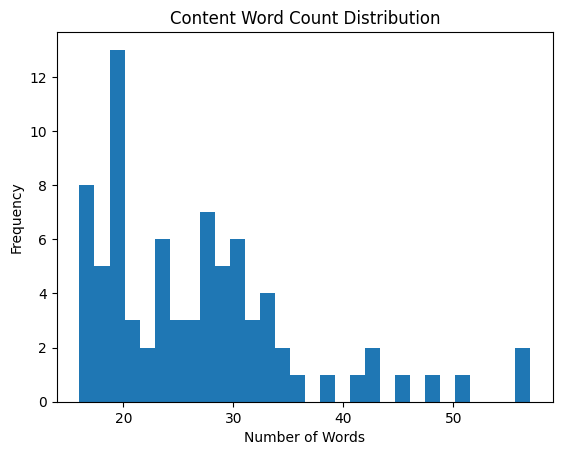

In [12]:
import matplotlib.pyplot as plt

plt.hist(content_stats["num_words"], bins=30)
plt.title("Content Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


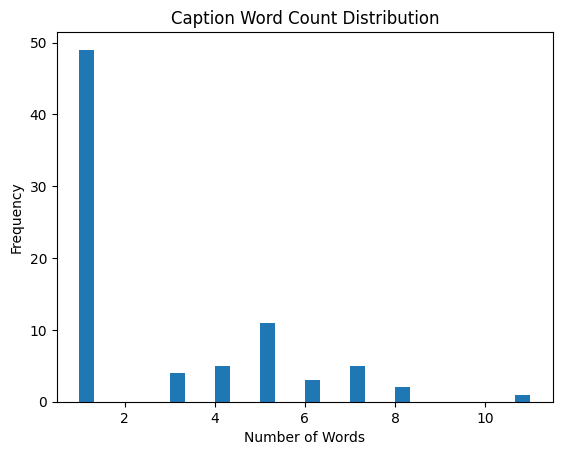

In [13]:
plt.hist(caption_stats["num_words"], bins=30)
plt.title("Caption Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


**GROUP WISE EDA**

In [14]:
df_train["content_word_count"] = content_stats["num_words"]

df_train.groupby("book_name")["content_word_count"].describe()


,count,mean,std,min,25%,50%,75%,max
book_name,,,,,,,,
In Search of the Castaways,49.0,29.918367,9.776325,17.0,23.0,27.0,33.0,57.0
The Count of Monte Cristo,31.0,22.096774,5.374972,16.0,18.0,20.0,27.5,32.0


In [15]:
def chunk_text(text, chunk_size=500, overlap=0):
    words = text.split()
    chunks = []
    
    i = 0
    while i < len(words):
        chunk = words[i:i + chunk_size]
        chunks.append(" ".join(chunk))
        i += chunk_size - overlap
    
    return chunks

In [16]:
chunk_sizes = [300, 600, 1000]

results = []

for size in chunk_sizes:
    df_train[f"num_chunks_{size}"] = df_train["content"].astype(str).apply(
        lambda x: len(chunk_text(x, chunk_size=size))
    )
    
    results.append({
        "chunk_size": size,
        "avg_chunks": df_train[f"num_chunks_{size}"].mean(),
        "max_chunks": df_train[f"num_chunks_{size}"].max()
    })

pd.DataFrame(results)


,chunk_size,avg_chunks,max_chunks
0,300,1.0,1
1,600,1.0,1
2,1000,1.0,1


In [17]:
df_train["char_in_content"] = df_train.apply(
    lambda row: str(row["char"]).lower() in str(row["content"]).lower(),
    axis=1
)

df_train["char_in_content"].value_counts(normalize=True)


char_in_content
False    0.9375
True     0.0625
Name: proportion, dtype: float64

In [18]:
df_train["char_in_caption"] = df_train.apply(
    lambda row: str(row["char"]).lower() in str(row["caption"]).lower(),
    axis=1
)

df_train["char_in_caption"].value_counts(normalize=True)


char_in_caption
False    1.0
Name: proportion, dtype: float64

In [19]:
pd.crosstab(
    df_train["char_in_content"],
    df_train["char_in_caption"],
    normalize="all"
)


char_in_caption,False
char_in_content,
False,0.9375
True,0.0625


In [20]:
import re

df_train["caption_words"] = df_train["caption"].astype(str).str.split().str.len()

df_train["caption_words"].describe()

count    80.000000
mean      2.700000
std       2.409895
min       1.000000
25%       1.000000
50%       1.000000
75%       5.000000
max      11.000000
Name: caption_words, dtype: float64

In [21]:
verb_like = [
    "is", "was", "were", "are", "did", "does", "made", "makes",
    "showed", "shows", "acted", "acts", "refused", "refuses"
]

df_train["caption_has_verb"] = df_train["caption"].astype(str).apply(
    lambda x: any(v in x.lower().split() for v in verb_like)
)

df_train["caption_has_verb"].value_counts(normalize=True)


caption_has_verb
False    1.0
Name: proportion, dtype: float64

In [22]:
negations = ["not", "never", "no", "none", "without"]

df_train["caption_has_negation"] = df_train["caption"].astype(str).apply(
    lambda x: any(n in x.lower().split() for n in negations)
)

df_train["caption_has_negation"].value_counts(normalize=True)


caption_has_negation
False    1.0
Name: proportion, dtype: float64

In [23]:
df_train["has_caption"] = df_train["caption"].notna()

df_train["has_caption"].value_counts(normalize=True)

has_caption
False    0.6125
True     0.3875
Name: proportion, dtype: float64

In [24]:
pd.crosstab(
    df_train["has_caption"],
    df_train["label"],
    normalize="index"
)


label,consistent,contradict
has_caption,,
False,0.734694,0.265306
True,0.483871,0.516129


In [25]:
pd.crosstab(
    df_train["book_name"],
    df_train["has_caption"],
    normalize="index"
)


has_caption,False,True
book_name,,
In Search of the Castaways,1.0,0.0
The Count of Monte Cristo,0.0,1.0


**Task A — Narrative Plausibility (Castaways)

* No caption

* Judge if the passage fits the character’s story arc

* Mostly consistent

* Requires:

world knowledge

event plausibility

causal continuity

Task B — Attribute Verification (Monte Cristo)

* Caption present

* Judge if an attribute matches behavior

* Balanced labels

* Requires:

trait inference

moral/psychological reasoning**

In [26]:
POSITIVE_OUTCOMES = [
    "success", "won", "saved", "helped", "advanced", "secured",
    "gained", "protected", "achieved", "calm", "order"
]

NEGATIVE_OUTCOMES = [
    "failed", "lost", "defeated", "destroyed", "fled", "retreated",
    "panic", "chaos", "injured", "killed", "mistake"
]

In [27]:
def outcome_probe(text, word_list):
    text = str(text).lower()
    return any(w in text for w in word_list)

df_train["has_positive_outcome"] = df_train["content"].apply(
    lambda x: outcome_probe(x, POSITIVE_OUTCOMES)
)

df_train["has_negative_outcome"] = df_train["content"].apply(
    lambda x: outcome_probe(x, NEGATIVE_OUTCOMES)
)


In [28]:
pd.crosstab(
    df_train["has_positive_outcome"],
    df_train["label"],
    normalize="index"
)


label,consistent,contradict
has_positive_outcome,,
False,0.6,0.4
True,0.9,0.1


In [29]:
pd.crosstab(
    df_train["has_negative_outcome"],
    df_train["label"],
    normalize="index"
)


label,consistent,contradict
has_negative_outcome,,
False,0.630137,0.369863
True,0.714286,0.285714


**When the content contains positive-progress language, the sample is very likely consistent. Negative outcomes do NOT strongly imply contradiction.**